# Street View House Numbers Classification

The Street View House Numbers (SVHN) dataset is one of the most popular benchmarks for object recognition tasks in academic papers. The images were obtained from house numbers in Google Street View images, are hosted by Stanford University and are very similar in philosophy with the MNIST dataset. However, the original purpose of this dataset is to solve a harder problem: that of recognizing digits and numbers in natural scene images.

The data of the Street View House Numbers dataset, which can originally be found [here](http://ufldl.stanford.edu/housenumbers) are originally in .mat, i.e. files which can be best processed with MATLAB; thus, some preprocessing is required (see section 2). It is important to note that the data are divided into two formats and in this particular kernel we are going to use **Format 2**:

- *Format 1*: The original, variable-resolution colored house-number images with character level bounding boxes.
- *Format 2*: The cropped digits (32x32 pixels) which follow the philosophy of the MNIST dataset more closely, but also contain some distracting digits to the sides of the digit of interest.

## 1. Imports

In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
%matplotlib inline

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D,Lambda, Conv2DTranspose, MaxPooling2D,ZeroPadding2D, UpSampling2D, Input, Reshape, GlobalAveragePooling2D, Concatenate,MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import tensorflow.keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

In [2]:
# Set random state

np.random.seed(20)

## 2. Loading and preprocessing

In [3]:
# Load the data

train_raw = loadmat('../input/svhndataset/train_32x32.mat')
test_raw = loadmat('../input/svhndataset/test_32x32.mat')

In [4]:
# Load images and labels

train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']

In [5]:
# Check the shape of the data

print(train_images.shape)
print(test_images.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [6]:
# Fix the axes of the images

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


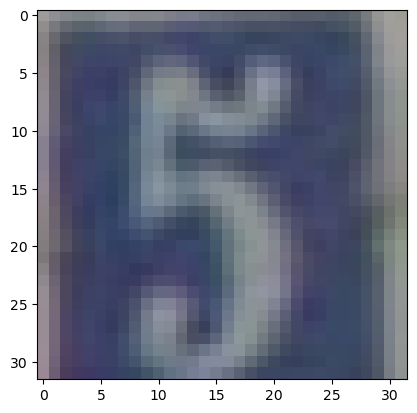

Label:  [5]


In [7]:
# Plot a random image and its label

plt.imshow(train_images[13529])
plt.show()

print('Label: ', train_labels[13529])

In [8]:
# Convert train and test images into 'float64' type

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

In [9]:
# Convert train and test labels into 'int64' type

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [10]:
# Normalize the images data

print('Min: {}, Max: {}'.format(train_images.min(), train_images.max()))

train_images /= 255.0
test_images /= 255.0

Min: 0.0, Max: 255.0


In [11]:
# One-hot encoding of train and test labels

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,
                                                  test_size=0.15, random_state=22)

In [13]:
y_train.shape

(62268, 10)

In [14]:
def resnet50(input_shape):
    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(10, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [15]:
model = resnet50((32, 32, 3))

2023-02-19 06:45:20.025748: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-02-19 06:45:20.025807: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [16]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
#history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val))

In [18]:
#model.save_weights('ResnetWeights.h5')

In [19]:
history = model.load_weights('../input/resnetweight/ResnetWeights.h5')

In [20]:
result = model.evaluate(X_val, y_val)
print("Test: loss = %f accuracy = %f  ;" % (result[0], result[1]))

344/344 [==============================] - 32s 85ms/step - loss: 0.4157 - accuracy: 0.8950
Test: loss = 0.415683 accuracy = 0.894986  ;


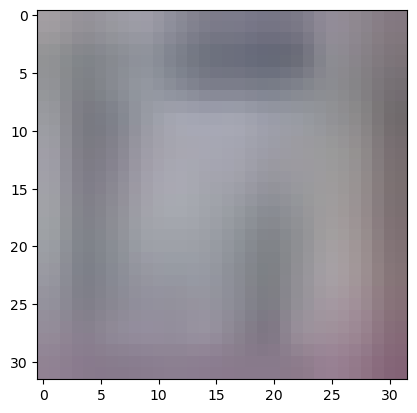

In [21]:
img = X_train[3000]
plt.imshow(img)
plt.show()

In [22]:
model.predict(img.reshape(1,32,32,3)).argmax()

1/1 [==============================] - 1s 1s/step


6

In [23]:
iterations = 7
alpha = 2
epsilon = 8/255

In [24]:
def pgd(img,label,model):
    gen_img = tf. convert_to_tensor(img.reshape(1,32,32,3),dtype=tf.dtypes.float32)
    gen_img = gen_img + tf.random.uniform(gen_img.get_shape().as_list(), minval=-epsilon, maxval=epsilon, dtype=tf.dtypes.float32)
    x_temp = img
    label = label.reshape(1,10)
    for iters in range(iterations):
        imgv = tf.Variable(gen_img)
        with tf.GradientTape() as tape:
            tape.watch(imgv)
            predictions = model(imgv)
            loss = tf.keras.losses.CategoricalCrossentropy()(label, predictions)
            grads = tape.gradient(loss,imgv)
        signed_grads = tf.sign(grads)
        gen_img = gen_img + (alpha*signed_grads)
        gen_img = tf.clip_by_value(gen_img, img-epsilon, img+epsilon)
    return gen_img

In [25]:
img = pgd(X_train[3000],y_train[3000],model)

In [26]:
img= img.numpy()

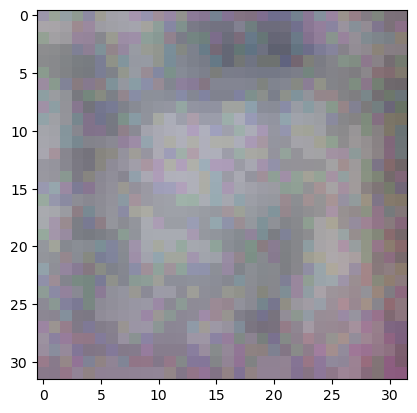

In [27]:
plt.imshow(img.reshape(32,32,3))
plt.show()

In [28]:
model.predict(img.reshape(1,32,32,3)).argmax()

1/1 [==============================] - 0s 42ms/step


1

In [29]:
height=32
width=32
channels=3

In [30]:
len(X_val)

10989

In [31]:
#generating xtest_set with pgd
def pgd_set(X_val,y_val,model):
    i=0
    xval1 = np.zeros(shape=(len(X_val),32,32,3))
    for x in X_val:
        x = x.reshape(1,height,width, channels)
        xval1[i] = pgd(x,y_val[i],model)
        i = i+1
    return xval1

In [32]:
def mobnet_unet(input_shape):
    input_tensor = Input(shape=input_shape)
    base_model = MobileNetV2(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(10, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model
model1 = mobnet_unet((32, 32, 3))

In [33]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model1.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
#history1 = model1.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val))

In [35]:
#model1.save_weights('MobNetWeights.h5')

In [36]:
history1 = model1.load_weights('../input/mobnetweights/MobNetWeights.h5')

In [43]:
y_val.shape

(10989, 10)

In [45]:
X_val_small = np.zeros(shape=(100,32,32,3))
y_val_small = np.zeros(shape=(100,10))
for x in range(0,99):
    X_val_small[x] = X_val[x]
    y_val_small[x] = y_val[x]

## Result of applying pgd on RESNET

In [47]:
xval1 = pgd_set(X_val_small,y_val_small,model)
result = model.evaluate(xval1, y_val_small)
print("Test: loss = %f accuracy = %f  ;" % (result[0], result[1]))

4/4 [==============================] - 1s 65ms/step - loss: 8.4083 - accuracy: 0.1300
Test: loss = 8.408314 accuracy = 0.130000  ;


## Result of applying pgd on UNET

In [48]:
xval2 = pgd_set(X_val_small,y_val_small,model)
result = model1.evaluate(xval2, y_val_small)
print("Test: loss = %f accuracy = %f  ;" % (result[0], result[1]))

4/4 [==============================] - 2s 21ms/step - loss: 2.2147 - accuracy: 0.1800
Test: loss = 2.214663 accuracy = 0.180000  ;


## Normal result on small set

In [49]:
result = model.evaluate(X_val_small, y_val_small)
print("Test: loss = %f accuracy = %f  ;" % (result[0], result[1]))

4/4 [==============================] - 0s 70ms/step - loss: 0.4482 - accuracy: 0.8700
Test: loss = 0.448232 accuracy = 0.870000  ;
